# Setup

In [ ]:
from google.colab import drive
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Pipeline


In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:

file_path = "/content/drive/MyDrive/24fall_dlProject/data/BTC-USD_stock_data.csv"

data = pd.read_csv(file_path,index_col='Date',parse_dates=['Date'])
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-01,963.658020,1003.080017,958.698975,998.325012,998.325012,147775008
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,1021.750000,222184992
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,1043.839966,185168000
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,1154.729980,344945984
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,1013.380005,510199008


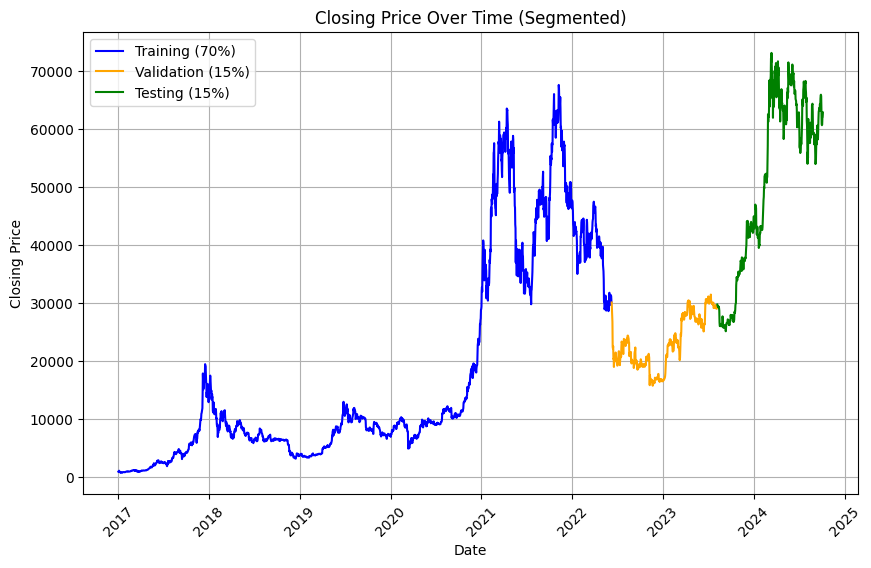

In [ ]:
close_data = data['Close'].values  # Get 'Close' data as a NumPy array
total_data_points = len(close_data)
segment1_end = int(total_data_points * 0.7)
segment2_end = int(total_data_points * (0.7 + 0.15))

plt.figure(figsize=(10, 6))

# Plotting segments with different colors
plt.plot(data.index[:segment1_end], close_data[:segment1_end], label='Training (70%)', color='blue')
plt.plot(data.index[segment1_end:segment2_end], close_data[segment1_end:segment2_end], label='Validation (15%)', color='orange')
plt.plot(data.index[segment2_end:], close_data[segment2_end:], label='Testing (15%)', color='green')

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Closing Price Over Time (Segmented)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [ ]:
def data_preprocessing_with_closed_price_and_min_max_scaler(data, seq_length=60):
    train_ratio = 0.7
    val_ratio = 0.15
    new_data = data.drop(columns=["Adj Close"])
    close_data = new_data.values.reshape(2836, 5)
    scaler = MinMaxScaler(feature_range=(0, 10))
    data_scaled = scaler.fit_transform(close_data)
    data_scaled = pd.DataFrame(data_scaled)

    def create_feature_datasets(data, x_size):
        x_datasets = []
        y_datasets = []
        for i in range(len(data) - x_size):
            x = data[i:i + x_size].values.reshape(-1, 5)
            y = data[i + x_size:i + x_size + 1][3].values.reshape(1)
            x_datasets.append(x)
            y_datasets.append(y)
        X = np.array(x_datasets)
        y = np.array(y_datasets)
        X_train =  X[:int(len(X) * train_ratio)]
        y_train = y[:int(len(y) * train_ratio)]
        X_val = X[int(len(X) * train_ratio):int(len(X) * (train_ratio + val_ratio))]
        y_val = y[int(len(y) * train_ratio):int(len(y) * (train_ratio + val_ratio))]
        X_test = X[int(len(X) * (train_ratio + val_ratio)):]
        y_test = y[int(len(y) * (train_ratio + val_ratio)):]

        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]

        return torch.Tensor(X_train_shuffled).to(device), torch.Tensor(X_val).to(device), torch.Tensor(X_test).to(device), torch.Tensor(y_train_shuffled).to(device), torch.Tensor(y_val).to(device), torch.Tensor(y_test).to(device)

    return create_feature_datasets(data_scaled, seq_length), scaler

(X_train, X_val, X_test, y_train, y_val, y_test), min_max_scaler = data_preprocessing_with_closed_price_and_min_max_scaler(data, 60)

# Auxiliary functions

In [ ]:
def calculate_daily_long_trade_return_percentage(predicted_prices, true_prices):
  def generate_daily_trade_signals_long_only(predicted_prices, true_prices):
    signals = torch.zeros_like(predicted_prices)
    signals[:-1] = torch.where(predicted_prices[1:] > predicted_prices[:-1], 1, 0)  # Buy if tomorrow's predicted price > today's
    return signals

  signals = generate_daily_trade_signals_long_only(predicted_prices, true_prices)

  # Calculate price differences and percentage change
  price_diff = true_prices[1:] - true_prices[:-1]
  percentage_returns = (price_diff / true_prices[:-1])  # Convert to percentage change
  # Calculate returns based on signals
  returns = signals[:-1] * percentage_returns

  # Step 1: Calculate cumulative returns
  cumulative_returns = torch.cumprod(1 + returns, dim=0)

  # Step 2: Calculate running maximum of cumulative returns
  running_max, _ = torch.cummax(cumulative_returns, dim=0)

  # Step 3: Calculate drawdowns
  drawdowns = (cumulative_returns - running_max) / running_max

  # Step 4: Find the maximum drawdown
  max_drawdown = drawdowns.min()

  lt_return = cumulative_returns[-1].item() - 1

  print("Return:", lt_return)
  print("Max Drawdown:", max_drawdown.item())

  return lt_return, max_drawdown.item()

In [ ]:
# create a nn class (just-for-fun choice :-)
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

# Baseline Model

In [ ]:
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)  # Initial hidden state
        c_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)  # Initial cell state
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])  # Get the output from the last time step
        return out

# Training Function

In [ ]:
def train_model(batch_size, hidden_size, num_layers, dropout, learning_rate, input_size=5, output_size=1, num_epochs=200):

  # Create dataset and DataLoader for batching
  dataset = TensorDataset(X_train, y_train)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  # Model, loss, optimizer
  model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout)
  model.to(device)
  criterion = RMSELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  epoch_losses = []

  # Training loop with batching
  for epoch in range(num_epochs):
      model.train()
      for batch_idx, (batch_x, batch_y) in enumerate(dataloader):
          optimizer.zero_grad()
          outputs = model(batch_x)
          loss = criterion(outputs, batch_y)
          loss.backward()
          optimizer.step()

      epoch_losses.append(loss.item())
      if (epoch + 1) % 10 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

  # plt.figure(figsize=(8, 6))
  # plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', label='Training Loss')
  # plt.xlabel('Epoch')
  # plt.ylabel('Loss')
  # plt.title('Loss Curve')
  # plt.legend()
  # plt.grid()
  # plt.show()

  model.eval()
  with torch.no_grad():
      predictions = model(X_train)

  y_train.to(device)
  train_ur = torch.sqrt(torch.mean((predictions - y_train) ** 2))

  if device == torch.device("cuda"):
      predictions_cpu = predictions.cpu()
      y_train_cpu = y_train.cpu()

  # Reverse the scaling
  predictions_reversed = torch.Tensor(min_max_scaler.inverse_transform(np.repeat(predictions_cpu.numpy(), 5, axis=1)))[:, 3]
  y_train_reversed = torch.Tensor(min_max_scaler.inverse_transform(np.repeat(y_train_cpu.numpy(), 5, axis=1)))[:, 3]
  train_r = torch.sqrt(torch.mean((predictions_reversed - y_train_reversed) ** 2))

  # # Convert tensors to 1D for plotting
  # tensor1 = predictions_reversed.view(-1)
  # tensor2 = y_train_reversed.view(-1)

  # # Plotting the line chart
  # plt.figure(figsize=(8, 5))
  # plt.scatter(tensor1.numpy(), tensor2.numpy(), label='Predictions vs GT', marker='o', s=10)

  # min_val = min(tensor1.min(), tensor2.min())
  # max_val = max(tensor1.max(), tensor2.max())
  # plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='-', label='Predictions = GT')

  # plt.title('Predictions vs GT on Training Set')
  # plt.xlabel('Predictions')
  # plt.ylabel('GT')
  # plt.legend()
  # plt.grid(True)
  # plt.show()

  model.eval()
  with torch.no_grad():
      predictions = model(X_val)
  val_ur = torch.sqrt(torch.mean((predictions - y_val) ** 2))

  if device == torch.device("cuda"):
      predictions_cpu = predictions.cpu()
      y_val_cpu = y_val.cpu()

  # Reverse the scaling
  predictions_reversed = torch.Tensor(min_max_scaler.inverse_transform(np.repeat(predictions_cpu.numpy(), 5, axis=1)))[:, 3]
  y_val_reversed = torch.Tensor(min_max_scaler.inverse_transform(np.repeat(y_val_cpu.numpy(), 5, axis=1)))[:, 3]
  val_r = torch.sqrt(torch.mean((predictions_reversed - y_val_reversed) ** 2))

  # # Convert tensors to 1D for plotting
  # tensor1 = predictions_reversed.view(-1)
  # tensor2 = y_val_reversed.view(-1)

  # # Plotting the line chart
  # plt.figure(figsize=(8, 5))
  # plt.plot(tensor1.numpy(), label='Predictions', marker='x')
  # plt.plot(tensor2.numpy(), label='GT', marker='.')
  # plt.title('Predictions vs GT on Validation Set')
  # plt.xlabel('Index')
  # plt.ylabel('Value')
  # plt.legend()
  # plt.grid(True)
  # plt.show()

  predicted_prices = predictions_reversed.view(-1)
  true_prices = y_val_reversed.view(-1)

  lt_return, max_drawdown = calculate_daily_long_trade_return_percentage(predicted_prices, true_prices)

  return val_ur, val_r, train_ur, train_r, lt_return, max_drawdown


# Load Spreadsheet and Train + Tune

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/24fall_dlProject/Fine-Tuning_LSTM_Five_Features.xlsx", sheet_name=None)


In [ ]:
for index, row in df["lstm_five"].iterrows():
  print(f"Currently at row {index+2}.")
  if not pd.isna(row["Val_loss_unreversed"]):
    continue

  batch_size = int(row["Batch_size"])
  hidden_size = int(row["Hidden_size"])
  num_layers = int(row["Num_layers"])
  dropout = float(row["Dropout"])
  learning_rate = float(row["Learning_rate"])

  val_ur, val_r, train_ur, train_r, lt_return, max_drawdown = train_model(batch_size, hidden_size, num_layers, dropout, learning_rate)
  df["lstm_five"].at[index, "Val_loss_unreversed"] = val_ur.item()
  df["lstm_five"].at[index, "Val_loss_reversed"] = val_r.item()
  df["lstm_five"].at[index, "Train_loss_unreversed"] = train_ur.item()
  df["lstm_five"].at[index, "Train_loss_reversed"] = train_r.item()
  df["lstm_five"].at[index, "Return"] = lt_return
  df["lstm_five"].at[index, "Max_drawdown"] = max_drawdown
  df["lstm_five"].to_excel("/content/drive/MyDrive/24fall_dlProject/Fine-Tuning_LSTM_Five_Features.xlsx", sheet_name="lstm_five", index=False)

Streaming output truncated to the last 5000 lines.
Epoch [140/200], Loss: 0.1428
Epoch [150/200], Loss: 0.2166
Epoch [160/200], Loss: 0.1711
Epoch [170/200], Loss: 0.1393
Epoch [180/200], Loss: 0.1450
Epoch [190/200], Loss: 0.1523
Epoch [200/200], Loss: 0.1133
Return: 0.31508326530456543
Max Drawdown: -0.23643849790096283
Currently at row 109.
Epoch [10/200], Loss: 2.1644
Epoch [20/200], Loss: 2.8735
Epoch [30/200], Loss: 0.5281
Epoch [40/200], Loss: 0.4853
Epoch [50/200], Loss: 0.9384
Epoch [60/200], Loss: 0.3042
Epoch [70/200], Loss: 0.4952
Epoch [80/200], Loss: 0.5041
Epoch [90/200], Loss: 0.5673
Epoch [100/200], Loss: 0.4461
Epoch [110/200], Loss: 0.2984
Epoch [120/200], Loss: 0.3174
Epoch [130/200], Loss: 0.2730
Epoch [140/200], Loss: 0.1662
Epoch [150/200], Loss: 0.2994
Epoch [160/200], Loss: 0.1750
Epoch [170/200], Loss: 0.1384
Epoch [180/200], Loss: 0.1052
Epoch [190/200], Loss: 0.2198
Epoch [200/200], Loss: 0.1539
Return: -0.11733990907669067
Max Drawdown: -0.41470950841903687